In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import itertools
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline
params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [6]:
data = pd.read_pickle('effect_imbal_enhanced.p')
print(len(data))

2042


In [7]:
data['sample_size'] = data.g1t + data.g2t
data = data.rename(columns={'imbal':'imbalance'})
data.head()

,g1m,g1f,g2m,g2f,g1_mean,g2_mean,num_parts1,num_parts2,num_measures1,num_measures2,g1t,g2t,g1_sd_sample,g2_sd_sample,imbalance,effect,sample_size
NCT00114127,6.0,7.0,11.0,4.0,67.900,53.7000,13,15,13,15,13.0,15.0,27.402190,30.596568,0.271795,0.140169,28.0
NCT00180479,469.0,200.0,218.0,114.0,0.140,0.2800,301,134,301,134,669.0,332.0,0.410000,0.480000,0.044420,0.019668,1001.0
NCT00405275,101.0,77.0,89.0,85.0,-2.120,-2.2900,154,155,154,155,178.0,174.0,1.280000,1.300000,0.055921,0.010684,352.0
NCT00446654,8.0,12.0,6.0,12.0,-0.010,0.0800,21,21,21,21,20.0,18.0,0.210000,0.250000,0.066667,0.091983,38.0
NCT00728754,15.0,14.0,17.0,15.0,-0.744,-0.8445,24,28,65,68,29.0,32.0,1.516511,1.186630,0.014009,0.008200,61.0


Column Definitions
Note: the group number betwen baseline measurements and outcome measurements are not necessarily consistent (upon investigation perhaps 10% of them have switched orders)

- Columns from Baseline Measurements
    - g1f: # females in group 1
    - g1m: # males in group 1
    - g1t: g1f + g1m
    - g2f: # females in group 2
    - g2m: # males in group 2
    - g2t: g2f + g2m
    - imbal: np.abs(g1m / g1t - g2m / g2t)
    
- Columns from Outcome Measurements
    - g1_mean: reported mean in group 1
    - g2_mean: reported mean in group 2
    - num_parts1: # participants in group 1
    - num_parts2: # participants in group 2
    - num_measures1: # of measurements taken in group 1 (for example if each eye was measured)
    - num_measures2: # of measurements taken in group 2 (for example if each eye was measured)
    - g1_sd_sample: standard dev of mesurements in group 1
    - g2_sd_sample standard dev of mesurements in group 2
    - effect: normalized diff in means as described above

## Documenting the prevalence of imbalance

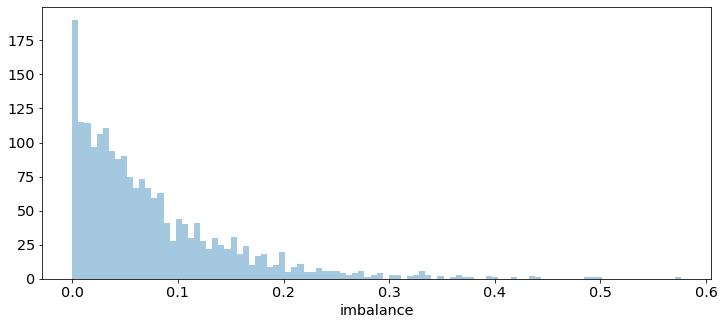

In [9]:
sns.distplot(data['imbalance'], kde=False, bins=100)

In [17]:
data.imbalance.describe(np.arange(0, 1, 0.05))

count    2042.000000
mean        0.074918
std         0.073788
min         0.000000
0%          0.000000
5%          0.000015
10%         0.006428
15%         0.011601
20%         0.016667
25%         0.022858
30%         0.028430
35%         0.033367
40%         0.040000
45%         0.046423
50%         0.052886
55%         0.061538
60%         0.070006
65%         0.079545
70%         0.089497
75%         0.104762
80%         0.121159
85%         0.142988
90%         0.170677
95%         0.216777
max         0.576190
Name: imbalance, dtype: float64

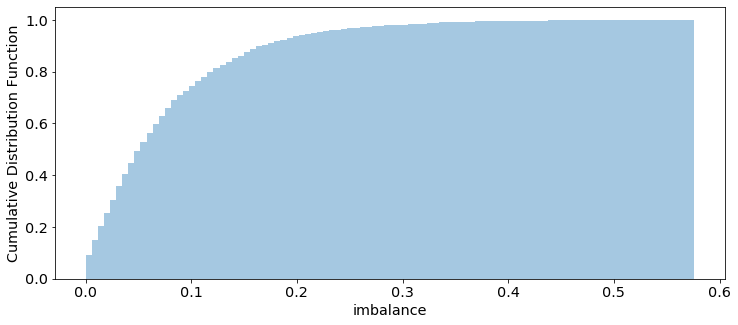

In [19]:
sns.distplot(
    data['imbalance'], kde=False, hist_kws={'cumulative': True}, norm_hist=True,
    bins=100
)
plt.ylabel('Cumulative Distribution Function')
plt.show()

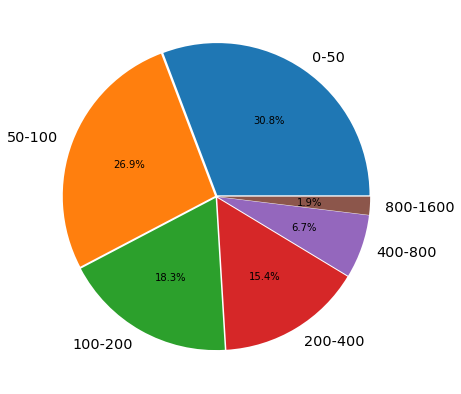

In [20]:
# trial size distribution
labels = []
shares = []

sample_sizes = [0, 50, 100, 200, 400, 800, 1600]
for i in range(len(sample_sizes)-1):
    lower, upper = sample_sizes[i:i+2]
    shares.append(
        data.sample_size.between(lower, upper).mean().round(2))
    labels.append('{}-{}'.format(lower, upper))    
    
plt.figure(figsize=(7, 7))
plt.pie(shares, explode=[.01] * len(shares), labels=labels, autopct='%.1f%%')
plt.show()

In [21]:
data.sample_size.describe()

count     2042.000000
mean       177.349657
std        491.706283
min         21.000000
25%         42.000000
50%         80.000000
75%        198.000000
max      17802.000000
Name: sample_size, dtype: float64

In [22]:
# ensure treatment and control groups are of similar sizes?
data = data.loc[np.log(data.g1t/data.g2t).abs() <= np.log(3)]
print(data.shape)

(2022, 17)


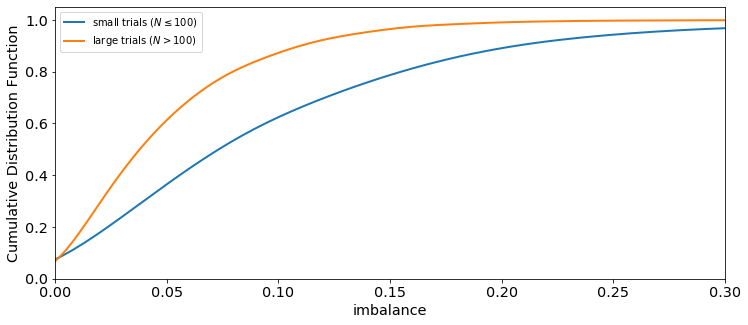

In [23]:
sns.distplot(
    data['imbalance'].loc[data.sample_size.between(0,100)], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": "small trials $(N \leq 100)$"}, 
    norm_hist=True, 
    bins=100
)
sns.distplot(
    data['imbalance'].loc[data.sample_size > 100], hist=False,
    kde_kws={'cumulative': True, "lw": 2, "label": 'large trials $(N > 100)$'}, 
    norm_hist=True,
    bins=100
)
plt.xlim(0, .3)
plt.ylabel('Cumulative Distribution Function')
plt.show()

In [24]:
# relative imbalance
def relative_imbalance(x):
    g1m, g1t, g2m, g2t = x
    s1, s2 = g1m/g1t, g2m/g2t
    return max(s1, s2)/min(s1, s2) -1

data['relative_imbalance'] = data[['g1m', 'g1t', 'g2m', 'g2t']].apply(
    relative_imbalance, axis=1
)
data.head()

/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,g1m,g1f,g2m,g2f,g1_mean,g2_mean,num_parts1,num_parts2,num_measures1,num_measures2,g1t,g2t,g1_sd_sample,g2_sd_sample,imbalance,effect,sample_size,relative_imbalance
NCT00114127,6.0,7.0,11.0,4.0,67.900,53.7000,13,15,13,15,13.0,15.0,27.402190,30.596568,0.271795,0.140169,28.0,0.588889
NCT00180479,469.0,200.0,218.0,114.0,0.140,0.2800,301,134,301,134,669.0,332.0,0.410000,0.480000,0.044420,0.019668,1001.0,0.067649
NCT00405275,101.0,77.0,89.0,85.0,-2.120,-2.2900,154,155,154,155,178.0,174.0,1.280000,1.300000,0.055921,0.010684,352.0,0.109330
NCT00446654,8.0,12.0,6.0,12.0,-0.010,0.0800,21,21,21,21,20.0,18.0,0.210000,0.250000,0.066667,0.091983,38.0,0.200000
NCT00728754,15.0,14.0,17.0,15.0,-0.744,-0.8445,24,28,65,68,29.0,32.0,1.516511,1.186630,0.014009,0.008200,61.0,0.027083


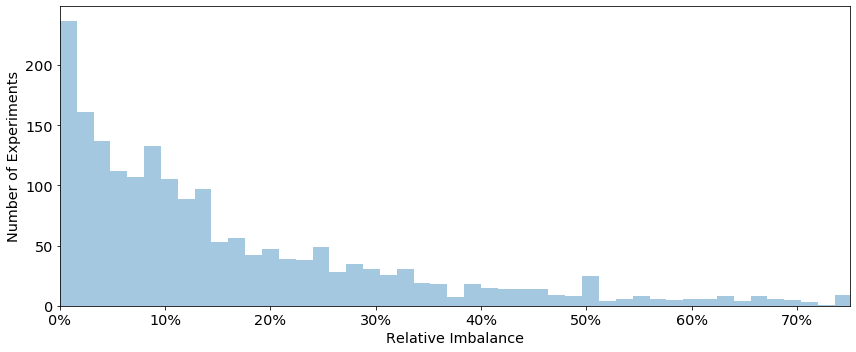

In [26]:
import matplotlib.ticker as mtick
ax = sns.distplot(
    data['relative_imbalance'], kde=False,
    hist_kws={'cumulative': False}, 
    bins=500
)
plt.ylabel('Number of Experiments')
plt.xlabel('Relative Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.))
plt.xlim(0,.75)
plt.tight_layout()
plt.savefig('figs/dist_relative_imbalance.pdf')
plt.show()

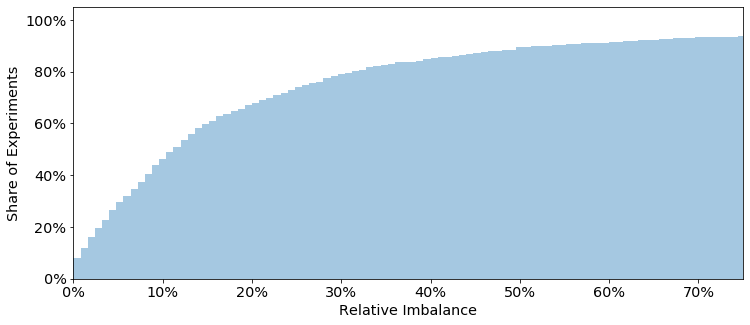

In [27]:
ax = sns.distplot(
    data['relative_imbalance'], kde=False,
    hist_kws={'cumulative': True}, norm_hist=True,
    bins=1000
)
plt.ylabel('Share of Experiments')
plt.xlabel('Relative Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
plt.xlim(0,.75)
plt.show()

In [28]:
data.relative_imbalance.describe()

count    2022.000000
mean        0.235330
std         0.399409
min         0.000000
25%         0.045010
50%         0.116251
75%         0.263158
max         8.000000
Name: relative_imbalance, dtype: float64

In [16]:
# share of all, small, large trials with relative imbalance greater than threshold

threshold = .25
for bounds in [0, 10000], [0, 100], [101, 10000], [101, 200]:
    print(
        bounds, '\t', 
        (data.loc[data.sample_size.between(*bounds)].relative_imbalance >= threshold).mean().round(3)
    )


[0, 10000] 	 0.27
[0, 100] 	 0.356
[101, 10000] 	 0.149
[101, 200] 	 0.212


In [17]:
# absolute imbalance for experiments with roughly 100 subjects

data.loc[data.sample_size.between(75, 125)].imbalance.describe()

count    342.000000
mean       0.070981
std        0.063978
min        0.000000
25%        0.023815
50%        0.054263
75%        0.102922
max        0.500000
Name: imbalance, dtype: float64

In [18]:
# share of all, small, large trials with low imbalance

threshold = .01
for bounds in [0, 10000], [0, 100], [101, 10000]:
    print(
        bounds, '\t', 
        (data.loc[data.sample_size.between(*bounds)].imbalance < threshold).mean().round(3)
    )

[0, 10000] 	 0.133
[0, 100] 	 0.112
[101, 10000] 	 0.162


In [19]:
# stats for imbalance
for bounds in [0, 10000], [0, 100], [101, 10000]:
    print(
        '\n', bounds, '\n', 
        data.loc[data.sample_size.between(*bounds)][['imbalance', 'relative_imbalance']].describe().round(3)
    )



 [0, 10000] 
        imbalance  relative_imbalance
count   2021.000            2021.000
mean       0.075               0.235
std        0.074               0.399
min        0.000               0.000
25%        0.023               0.045
50%        0.053               0.116
75%        0.105               0.263
max        0.576               8.000

 [0, 100] 
        imbalance  relative_imbalance
count   1181.000            1181.000
mean       0.094               0.307
std        0.084               0.488
min        0.000               0.000
25%        0.033               0.065
50%        0.071               0.151
75%        0.134               0.338
max        0.576               8.000

 [101, 10000] 
        imbalance  relative_imbalance
count    840.000             840.000
mean       0.049               0.134
std        0.044               0.178
min        0.000               0.000
25%        0.016               0.032
50%        0.037               0.084
75%        0.068              

## Structural analysis

we posit the data generating process


$$Y_i = scale \times (a + b \times Treatment + c \times Gender + \varepsilon_i)$$

with

$ b \sim N(0, \sigma_b) $

$ c \sim N(0, \sigma_c) $

$ \varepsilon_i \sim N(0, \sigma_e)$

This implies that

$$Y_t - Y_c = scale \times (b + c \times (G_t - G_c) + \Delta \varepsilon)$$

with 

$$\Delta \varepsilon \sim \mathcal N\left(0, \sqrt{\frac{\sigma_e^2}{N_t} + \frac{\sigma_e^2}{N_c}}\right)$$ 


Note that

$Var(Y_i | t) = scale^2 \sigma_e^2$

$Var(Y_i | c) = scale^2 \sigma_e^2$

This implies that 

$$\sigma_U \equiv \sqrt{\frac{N_t Var(Y_i | t) + N_c Var(Y_i | c)}{N_t + N_c}} = scale\times \sigma_e$$

Hence we have that

$$\text{signed effect} \equiv \frac{Y_t - Y_c}{\sigma_U} = \hat b + \hat c \times (G_t - G_c) + \hat \Delta \varepsilon$$

with 

$ \hat b \sim N(0, \hat \sigma_b) $

$ \hat c \sim N(0, \hat \sigma_c) $

$$\Delta \varepsilon \sim \mathcal N\left(0, \sqrt{\frac{1}{N_t} + \frac{1}{N_c}}\right)$$ 


Another implication is that (absent correlation between true treatment effect and sample size)

$$\mathbb E\left[\left(\frac{Y_t - Y_c}{\sigma_U}\right)^2 \Bigg| G_t, G_c, N_t, N_c \right] = \sigma_b^2 + \sigma_c^2 \times (G_t - G_c)^2 + \frac{1}{N_t} + \frac{1}{N_e}$$

This implies that one can recover $\sigma_b^2$ and $\sigma_c^2$ as the coefficients of a simple regression of the regression 

$$residuals \sim 1 + (G_t - G_c)^2$$ 

where 

$$residuals \equiv \left(\frac{Y_t - Y_c}{\sigma_U}\right)^2 - \frac{1}{N_t} - \frac{1}{N_e}$$ 

In [20]:
# additional variables

def average_sd(x):
    g1t, g2t, g1_sd_sample, g2_sd_sample = x
    return np.sqrt(g1t * g1_sd_sample **2 + g2t * g2_sd_sample ** 2) / np.sqrt(g1t + g2t)
    
data['average_sd'] = data[['g1t', 'g2t', 'g1_sd_sample', 'g2_sd_sample']].apply(
    average_sd, axis=1
)
data.head().T

,NCT00114127,NCT00180479,NCT00405275,NCT00446654,NCT00728754
g1m,6.000000,469.000000,101.000000,8.000000,15.000000
g1f,7.000000,200.000000,77.000000,12.000000,14.000000
g2m,11.000000,218.000000,89.000000,6.000000,17.000000
g2f,4.000000,114.000000,85.000000,12.000000,15.000000
g1_mean,67.900000,0.140000,-2.120000,-0.010000,-0.744000
g2_mean,53.700000,0.280000,-2.290000,0.080000,-0.844500
num_parts1,13.000000,301.000000,154.000000,21.000000,24.000000
num_parts2,15.000000,134.000000,155.000000,21.000000,28.000000
num_measures1,13.000000,301.000000,154.000000,21.000000,65.000000
num_measures2,15.000000,134.000000,155.000000,21.000000,68.000000


In [21]:
data['signed_effect'] = (data['g1_mean'] - data['g2_mean']) / data['average_sd']
data['effect_size'] = data.signed_effect.abs()
data['bias'] = (1/data.g1t) + (1/data.g2t)
data['inverse_sample_size'] = 1/data.sample_size
data = data.loc[data.signed_effect.abs() < 3]

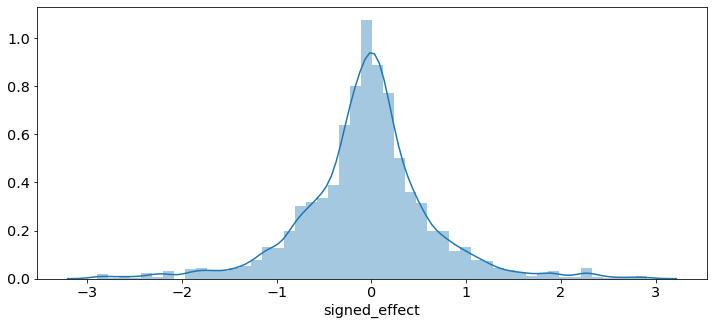

In [22]:
sns.distplot(data.signed_effect)

In [23]:
selected_data = data.copy()
selected_data = selected_data.loc[selected_data.imbalance.between(.02, .25)]

In [24]:
selected_data['residuals'] = np.square(selected_data.signed_effect
                                       - selected_data.signed_effect.mean()) - selected_data.bias
selected_data['square_imbalance'] = np.square(selected_data.imbalance)

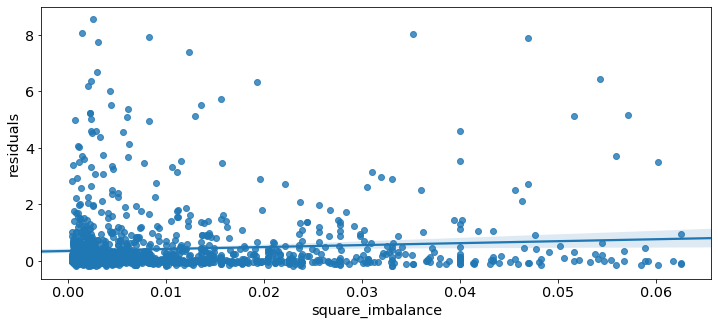

In [25]:
sns.regplot('square_imbalance', 'residuals', selected_data)

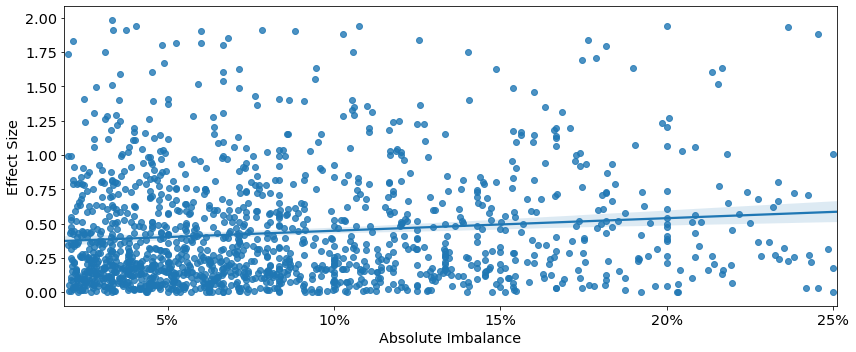

In [38]:
ax = sns.regplot('imbalance', 'effect_size', selected_data.loc[selected_data.effect_size <2])
plt.ylabel('Effect Size')
plt.xlabel('Absolute Imbalance')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.xlim(0.019,.251)
plt.tight_layout()
plt.savefig('figs/regplot_imbalance_effect_size.pdf')
plt.show()

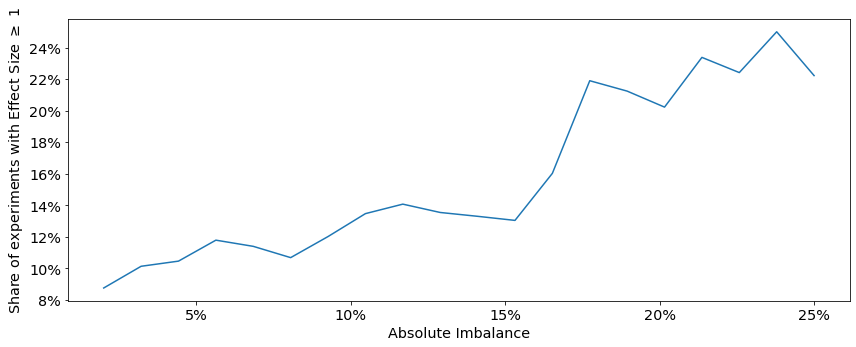

In [39]:
step = .025
share_large_effects = []

for imbalance in np.linspace(.02, .25, 20):
    is_large = (selected_data.loc[selected_data.imbalance.between(imbalance - step, imbalance + step)
                             ].effect_size >= 1)
    share_large_effects.append(is_large.mean())
    std_error = [is_large.std()]
share_large_effects

fig, ax = plt.subplots()
plt.plot(np.linspace(.02, .25, 20), share_large_effects)
plt.xlabel('Absolute Imbalance')
plt.ylabel('Share of experiments with Effect Size $\geq$ 1')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.tight_layout()
plt.savefig('figs/regplot_imbalance_large_effect_size.pdf')
plt.show()

In [28]:
mod = smf.ols('effect_size ~ imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     19.72
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           9.64e-06
Time:                        08:39:25   Log-Likelihood:                -1065.7
No. Observations:                1466   AIC:                             2135.
Df Residuals:                    1464   BIC:                             2146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3874      0.024     15.892      0.0

In [29]:
mod = smf.ols('effect_size ~ imbalance + inverse_sample_size' , selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            effect_size   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     26.29
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           6.07e-12
Time:                        08:39:31   Log-Likelihood:                -1049.7
No. Observations:                1466   AIC:                             2105.
Df Residuals:                    1463   BIC:                             2121.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3263    

In [30]:
mod = smf.ols('residuals ~ square_imbalance', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     9.718
Date:                Tue, 04 Feb 2020   Prob (F-statistic):            0.00186
Time:                        08:39:33   Log-Likelihood:                -2150.6
No. Observations:                1466   AIC:                             4305.
Df Residuals:                    1464   BIC:                             4316.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.3482      0.035  

In [31]:
mod = smf.ols('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7.610
Date:                Tue, 04 Feb 2020   Prob (F-statistic):           0.000515
Time:                        08:39:34   Log-Likelihood:                -2147.8
No. Observations:                1466   AIC:                             4302.
Df Residuals:                    1463   BIC:                             4318.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2764    

In [32]:
mod = smf.quantreg('residuals ~ square_imbalance', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:             0.001083
Model:                       QuantReg   Bandwidth:                      0.1228
Method:                 Least Squares   Sparsity:                       0.4140
Date:                Tue, 04 Feb 2020   No. Observations:                 1466
Time:                        08:39:35   Df Residuals:                     1464
                                        Df Model:                            1
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0279      0.007      4.019      0.000       0.014       0.042
square_imbalance     1.6649      0.437      3.806      0.000       0.807       2.523


/home/sylvain/.envs/py36-workspace/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


In [33]:
mod = smf.quantreg('residuals ~ square_imbalance + inverse_sample_size', selected_data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:              residuals   Pseudo R-squared:             0.001212
Model:                       QuantReg   Bandwidth:                      0.1218
Method:                 Least Squares   Sparsity:                       0.4159
Date:                Tue, 04 Feb 2020   No. Observations:                 1466
Time:                        08:39:35   Df Residuals:                     1463
                                        Df Model:                            2
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0246      0.009      2.655      0.008       0.006       0.043
square_imbalance        1.2399      0.467      2.653      0.008       0.323       2.157
inverse_sample_size     0.5685      0.481      1.182      0.237      -0.375       1.512


### Evaluating of gains from balance

Given true parameter $b \sim \mathcal N(0, \sigma_b)$, an equally-size arm experiment of sample size $n$ gives us a signal with distribution  $\mathcal N\left(b, \sigma\right)$  with 
$$\sigma^2 = \sigma_c^2 \times imbalance^2 + \frac{4}{n} $$

Removing imbalance, one could obtain a signal with the same precision but a smaller sample size $n'$ such that

\begin{align*}
\sigma_c^2 \times imbalance^2  + \frac{4}{n} &= \frac{4}{n'}\\
\iff n' =  \frac{4}{4 + \sigma_c^2 Imbalance^2 n} \times n
\end{align*}

similarly, removing imbalance keeping sample size the same is equivalent to an increased sample size $n'$ such that

\begin{align*}
\sigma_c^2 \times imbalance^2  + \frac{4}{n'} &= \frac{4}{n}\\
\iff n' =  \frac{4}{4 - \sigma_c^2 Imbalance^2 n} \times n
\end{align*}

In [34]:
def sample_reduction(I, n, sigma_c):
    return 4 / (4 + (sigma_c ** 2) * (I ** 2) * n)  

sample_reduction(.15, 100, .7)

0.7839294463498285

In [35]:
def sample_increase(I, n, sigma_c):
    return 4 / (4 - (sigma_c ** 2) * (I ** 2) * n)  

sample_increase(.071, 100, 1.1)

1.1799274285635062